In [36]:
import torchvision
import os
import tarfile
import numpy as np
from torchvision.datasets.utils import download_url
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
from torch.utils.data import random_split
import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams['figure.facecolor'] = '#ffffff'

In [4]:
data_dir='./data/cifar10/'
print(os.listdir(data_dir))

['test', 'train']


In [5]:
classes = os.listdir(data_dir + "/train")
print(classes)

['cat', 'dog', 'truck', 'bird', 'airplane', 'ship', 'frog', 'horse', 'deer', 'automobile']


In [6]:
stats = ((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
train_tfms=transforms.Compose([
    transforms.RandomCrop(32,padding=4,padding_mode='reflect'),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(*stats,inplace=True)
])
valid_tfms=transforms.Compose([transforms.ToTensor(),
        transforms.Normalize(*stats)
        ])

In [7]:
train_ds=ImageFolder(data_dir+'/train',train_tfms)
valid_ds=ImageFolder(data_dir+'/test',valid_tfms)

In [8]:
batch_size=400

In [9]:
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
valid_dl = DataLoader(valid_ds, batch_size*2, num_workers=4, pin_memory=True)

In [10]:
def denormalize(images,means,stds):
    means=torch.tensor(means).reshape(1,3,1,1)
    stds=torch.tensor(stds).reshape(1,3,1,1)
    return ((images*stds)+means)

def show_batch_denorm(dl):
    for images,labels in dl:
        fig,ax=plt.subplots(figsize=(12,12))
        ax.set_xticks([]);ax.set_yticks([])
        denorm_images=denormalize(images,*stats)
        ax.imshow(make_grid(denorm_images[:64],nrow=8).permute(1,2,0).clamp(0,1))
        break

In [11]:
def show_batch_norm(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images[:64], nrow=8).permute(1, 2, 0).clamp(0,1))
        break

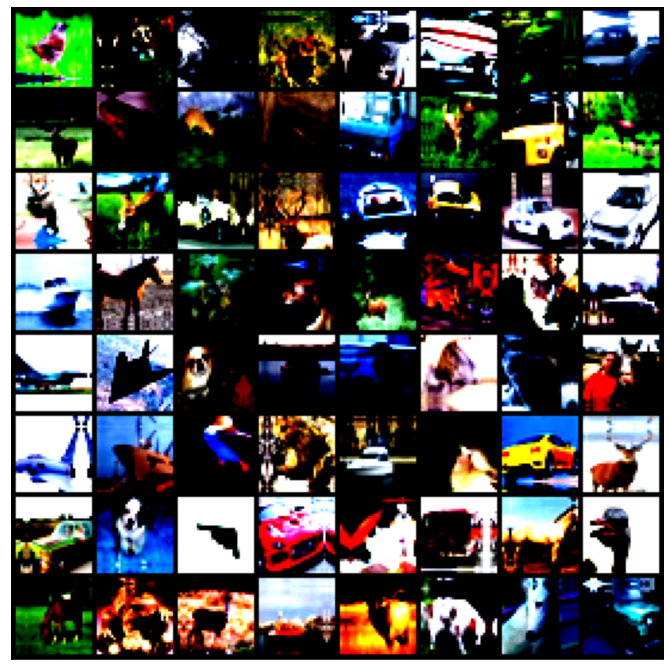

In [12]:
show_batch_norm(train_dl)

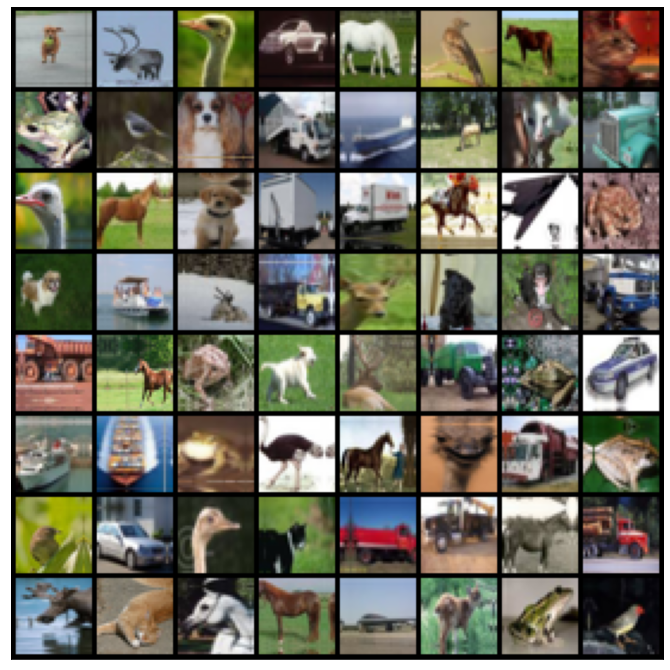

In [13]:
show_batch_denorm(train_dl)

In [14]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
    def __iter__(self):
        for b in self.dl: 
            yield to_device(b, self.device)
    def __len__(self):
        return len(self.dl)

In [15]:
device=get_default_device()
device

device(type='cpu')

In [16]:
train_dl=DeviceDataLoader(train_dl,device)
valid_dl=DeviceDataLoader(valid_dl,device)

In [17]:
def accuracy(outputs, labels):
    _,preds=torch.max(outputs,dim=1)
    return torch.tensor(torch.sum(preds==labels).item()/len(preds))

In [18]:
class ImageClassificationBase(nn.Module):
    def training_step(self,batch):
        images,labels=batch
        out=self(images)                
        loss=F.cross_entropy(out,labels)
        return loss
    def validation_step(self,batch):
        images,labels=batch
        out=self(images)
        loss=F.cross_entropy(out,labels)
        acc=accuracy(out,labels)
        return {'val_loss': loss.detach(), 'val_acc': acc}
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    def epoch_end(self, epoch, result):
        print(f"Epoch [{epoch}], last_lr: {result['lrs'][-1]}, train_loss: {result['train_loss']}, val_loss: {result['val_loss']}, val_acc: {result['val_acc']}")

In [19]:
def conv_block(in_channels,out_channels,pool=False):
    layers=[nn.Conv2d(in_channels,out_channels,kernel_size=3,padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)]
    if pool:
        layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet9(ImageClassificationBase):
    def __init__(self,in_channels,num_classes):
        super().__init__()

        self.conv1=conv_block(in_channels,64)
        self.conv2=conv_block(64,128,pool=True)
        self.res1=nn.Sequential(conv_block(128,128),conv_block(128,128))
        self.conv3 = conv_block(128, 256, pool=True)
        self.conv4 = conv_block(256, 512, pool=True)
        self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))
        self.classifier = nn.Sequential(nn.MaxPool2d(4), 
                                        nn.Flatten(), 
                                        nn.Dropout(0.2),
                                        nn.Linear(512, num_classes))
    
    def forward(self,xb):
        out=self.conv1(xb)
        out=self.conv2(out)
        out=self.res1(out)+out
        out=self.conv3(out)
        out=self.conv4(out)
        out=self.res2(out)+out
        out=self.classifier(out)
        return out
    

In [20]:
model=to_device(ResNet9(3,10),device)
model

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

In [21]:
for images, labels in train_dl:
    out =model(images)
    print(out.shape)
    break

torch.Size([400, 10])


In [22]:
@torch.no_grad()

def evaluate(model,val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']


def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay) #custom optimiser with weight decay
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader))     # Set up one-cycle learning rate scheduler
    
    for epoch in range(epochs):
        model.train()         #training
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            if grad_clip: #gradient clipping
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            optimizer.step()
            optimizer.zero_grad()
            lrs.append(get_lr(optimizer)) #update learning rate
            sched.step()
        result = evaluate(model, val_loader) #validation
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [23]:
history = [evaluate(model, valid_dl)]
history

[{'val_loss': 2.3039278984069824, 'val_acc': 0.09586537629365921}]

In [28]:
epochs = 8
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func=torch.optim.Adam

In [29]:
history += fit_one_cycle(epochs, max_lr, model, train_dl, valid_dl, 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay, 
                             opt_func=opt_func)

Epoch [0], last_lr: 0.003929274947543202, train_loss: 1.406241536140442, val_loss: 1.0578378438949585, val_acc: 0.6319230794906616
Epoch [1], last_lr: 0.009352712767003208, train_loss: 1.0568764209747314, val_loss: 2.128556966781616, val_acc: 0.49182695150375366
Epoch [2], last_lr: 0.009719417773875232, train_loss: 0.8499243855476379, val_loss: 1.063814640045166, val_acc: 0.6262499690055847
Epoch [3], last_lr: 0.008117456539497631, train_loss: 0.6313624978065491, val_loss: 0.5913210511207581, val_acc: 0.7953847050666809
Epoch [4], last_lr: 0.005559840141227017, train_loss: 0.5171077847480774, val_loss: 0.7938936948776245, val_acc: 0.7531731128692627
Epoch [5], last_lr: 0.0028306099820869924, train_loss: 0.4020983874797821, val_loss: 0.40897586941719055, val_acc: 0.8603845834732056
Epoch [6], last_lr: 0.0007664159383425639, train_loss: 0.2922741770744324, val_loss: 0.30933183431625366, val_acc: 0.8952884078025818
Epoch [7], last_lr: 4e-08, train_loss: 0.21856904029846191, val_loss: 0.28

In [30]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs')

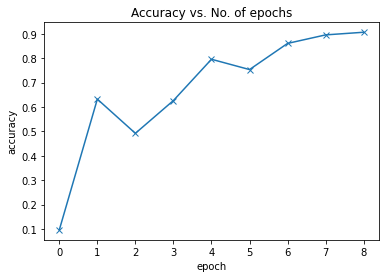

In [31]:
plot_accuracies(history)

In [32]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

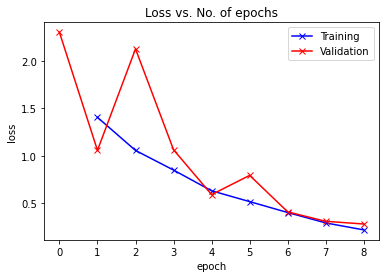

In [33]:
plot_losses(history)

In [37]:
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');

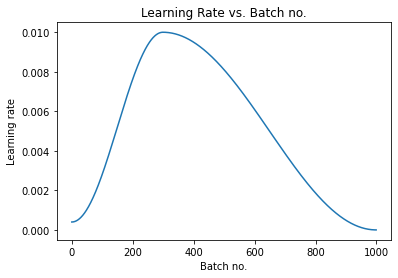

In [38]:
plot_lrs(history)

In [39]:
def predict_image(img, model):
    xb = to_device(img.unsqueeze(0), device)
    yb = model(xb)
    _, preds  = torch.max(yb, dim=1)
    return train_ds.classes[preds[0].item()]

Label: airplane , Predicted: airplane


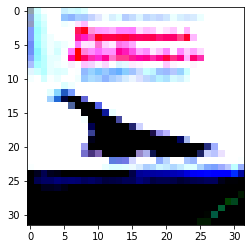

In [44]:
img, label = valid_ds[0]
plt.imshow(img.permute(1, 2, 0).clamp(0, 1))
print('Label:', train_ds.classes[label], ', Predicted:', predict_image(img, model))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: airplane , Predicted: airplane


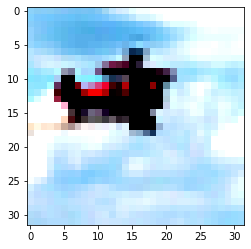

In [41]:
img, label = valid_ds[102]
plt.imshow(img.permute(1, 2, 0))
print('Label:', valid_ds.classes[label], ', Predicted:', predict_image(img, model))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: frog , Predicted: frog


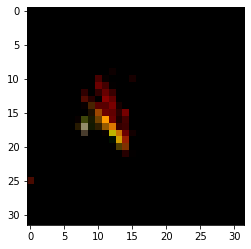

In [45]:
img, label = valid_ds[6143]
plt.imshow(img.permute(1, 2, 0))
print('Label:', train_ds.classes[label], ', Predicted:', predict_image(img, model))